In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import gmplot
%matplotlib inline

In [2]:
dfReset = pd.read_csv('../data/output_2/output_2.csv', parse_dates=['created_on'], infer_datetime_format=True)

In [3]:
dfReset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462286 entries, 0 to 1462285
Data columns (total 18 columns):
id                            1462286 non-null object
created_on                    1462286 non-null datetime64[ns]
property_type                 1462286 non-null object
place_name                    1462286 non-null object
state_name                    1462286 non-null object
lat                           1122304 non-null float64
lon                           1122293 non-null float64
price                         1462286 non-null float64
currency                      1457400 non-null object
price_aprox_local_currency    1462286 non-null float64
price_aprox_usd               1462286 non-null float64
surface_total_in_m2           1079918 non-null float64
surface_covered_in_m2         233333 non-null float64
price_usd_per_m2              1016393 non-null float64
price_per_m2                  226511 non-null float64
floor                         289280 non-null float64
rooms   

___
# Correcciones en el set
### Las correcciones en ésta sección fueron encontrándose a medida que se iba avanzando con el análisis exploratorio y se fueron agregando.
___

In [4]:
dfReset = dfReset.loc[(dfReset.surface_total_in_m2 <= 1000) & (dfReset.surface_total_in_m2 > 19)]
dfReset = dfReset.loc[(dfReset.price_usd_per_m2 <= 12000) & (dfReset.price_usd_per_m2 > 10)]

### Superficies y precios por m² excesivamente altos
>Realizando el plot de Superficie vs Precio USD m² se encontraron muchos outliers con superficies de 0 y excesivamente altas y precios de 0 y excesivamente altos.

In [5]:
def _pointInsideBsAs(lat, lon) :
    NO, NE, SE, SO = (-34.2560, -60.1354), (-34.2560, -57.0902), (-36.0219, -57.0902), (-36.0219, -60.1354)    
    return not ( (lat > NO[0]) or (lon < NO[1]) or (lon > NE[1]) or (lat < SE[0]) )

def pointInsideBsAs(latSeries, lonSeries) :    
    result = []
    
    for lat, lon in zip(latSeries, lonSeries) :
        result.append(_pointInsideBsAs(lat, lon))
    
    return np.array(result, dtype='bool')

dfReset.loc[(~pointInsideBsAs(dfReset.lat, dfReset.lon)) & 
                (dfReset.state_name.str.contains('Capital Federal'))]\
           .sort_values(by='created_on', ascending=False)\
           .head()\
           .loc[:, ('created_on', 'lat', 'lon', 'state_name', 'place_name')]

,created_on,lat,lon,state_name,place_name
1420213,2017-06-21,-38.416097,-63.616672,Capital Federal,Capital Federal
1411570,2017-06-09,-38.416097,-63.616672,Capital Federal,Capital Federal
1414193,2017-06-05,-38.416097,-63.616672,Capital Federal,Capital Federal
1396253,2017-05-31,-38.412634,-63.602510,Capital Federal,Capital Federal
1399535,2017-05-24,-26.861151,-65.213439,Capital Federal,Capital Federal


In [6]:
dfReset = dfReset.loc[pointInsideBsAs(dfReset.lat, dfReset.lon)]

### Saneamiento de latitud y longitud
>Mientras se hacía foco en éstos features (lat y lon) para realizar un plot, se encontraron latitudes y longitudes outliers como por ejemplo en África y en Arabia. Usando un poco Google Maps, se formó un cuadrado limítrofe alrededor de todo G.B.A. con los siguientes puntos:
+ **NO:** *(-34.2560, -60.1354)*
+ **NE:** *(-34.2560, -57.0902)*
+ **SE:** *(-36.0219, -57.0902)*
+ **SO:** *(-36.0219, -60.1354)*

>Como se puede observar en el segmento de tabla arriba, el place_name dice Capital Federal, sin embargo esas coordenadas están por fuera de Bs. As

In [7]:
dfReset.currency = dfReset.currency.astype('category')
dfReset.state_name = dfReset.state_name.astype('category')
dfReset.place_name = dfReset.place_name.astype('category')
dfReset.property_type = dfReset.property_type.astype('category')

### Features conversión de features catégoricos a categorías
>Es conveniente tenerlos representados de forma categórica para poder luego reemplazar los labels por valores numéricos para que operaciones de ordenamiento o por ejemplo de correlación tengan sentido.

In [8]:
dfReset = dfReset.reset_index(drop='index')
dfPublished = dfReset[:]     # Guardo una copia en dfReset por si quiero resetear el DataFrame en algún momento

In [9]:
dfPublished.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967710 entries, 0 to 967709
Data columns (total 18 columns):
id                            967710 non-null object
created_on                    967710 non-null datetime64[ns]
property_type                 967710 non-null category
place_name                    967710 non-null category
state_name                    967710 non-null category
lat                           725987 non-null float64
lon                           725976 non-null float64
price                         967710 non-null float64
currency                      967710 non-null category
price_aprox_local_currency    967710 non-null float64
price_aprox_usd               967710 non-null float64
surface_total_in_m2           967710 non-null float64
surface_covered_in_m2         156444 non-null float64
price_usd_per_m2              967710 non-null float64
price_per_m2                  154724 non-null float64
floor                         205435 non-null float64
rooms          

___
# Publicaciones VS Tiempo
___

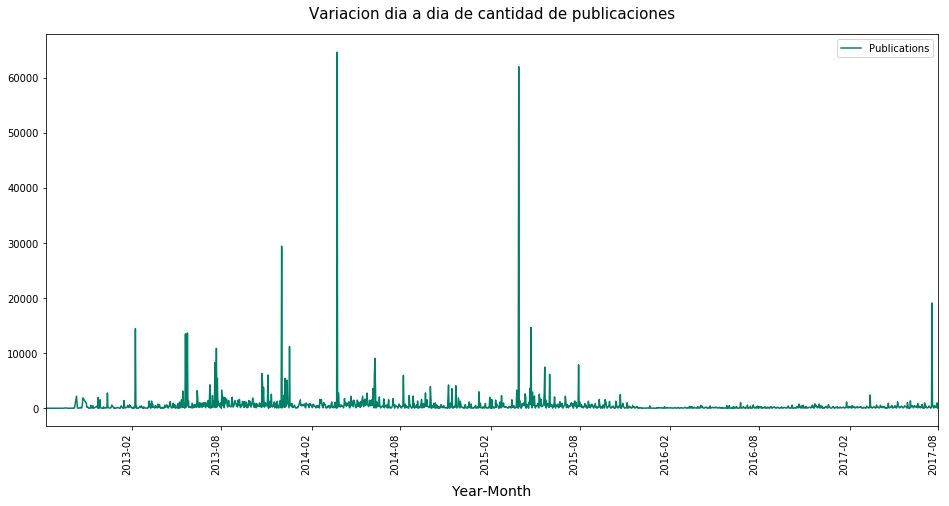

In [10]:
grouped = dfPublished[['created_on', 'id']].groupby(by='created_on').count().reset_index()
forPlot = grouped.rename(columns={'created_on':'Year-Month', 
                                  'id':'Publications'})
fig = forPlot.plot(x='Year-Month', 
                   figsize=(16, 8), 
                   colormap='summer', 
                   rot=90,
                   title="Variacion dia a dia de cantidad de publicaciones")
fig.xaxis.label.set_size(14)
fig.xaxis.set_label_coords(0.5, -0.15)
fig.title.set_size(15)
fig.title.set_position((0.5, 1.025));

In [11]:
forPlot.sort_values(by='Publications', ascending=False).head()

,Year-Month,Publications
502,2014-03-25,64607
859,2015-03-30,61968
393,2013-12-02,29399
1689,2017-07-19,19101
884,2015-04-24,14643


### ¿Que pasó en esas dos fechas que en un solo día hubo tantas ventas?
>**25 de Marzo de 2014:** Se buscaron noticias en Google filtrando por esa fecha acerca de bienes raíces y la situación económica del país para ver si se encontraba algún motivo que respaldara la enorme cantidad de publicaciones en un solo día. No se encontró nada lo suficientemente fuerte que explicara éste fenómeno. En el contexto mundial, fue la época en que se estaban vendiendo propiedades en Europa por precios extremadamente bajos debido a la crisis.<br>**30 de Marzo de 2015:** Se realizó la misma búsqueda sin un resultado que lo explique.

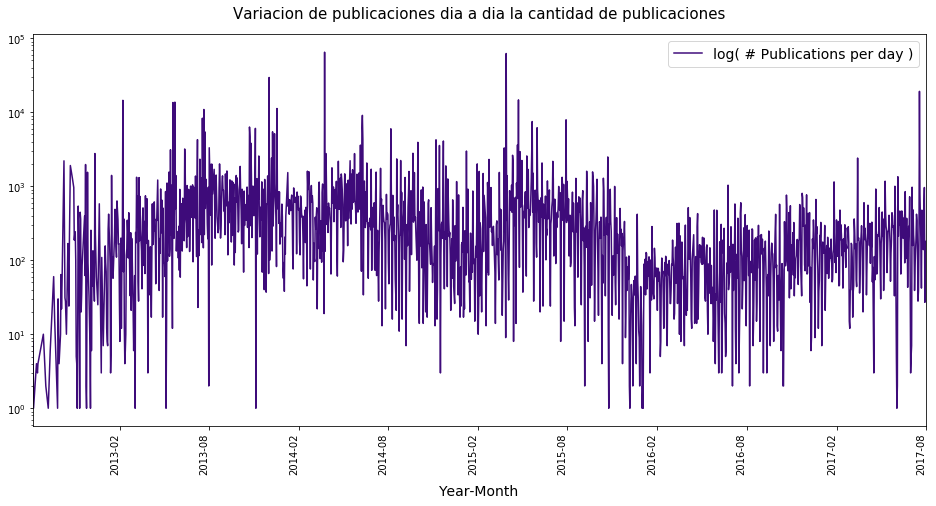

In [12]:
fig = forPlot.plot(x='Year-Month', 
                   figsize=(16, 8), 
                   color='#3e0b7a', 
                   logy=True, 
                   rot=90,
                   title="Variacion de publicaciones dia a dia la cantidad de publicaciones")
fig.xaxis.label.set_size(14)
fig.xaxis.set_label_coords(0.5, -0.15)
fig.title.set_size(15)
fig.legend(fontsize=14).get_texts()[0].set_text("log( # Publications per day )")
fig.title.set_position((0.5, 1.025));

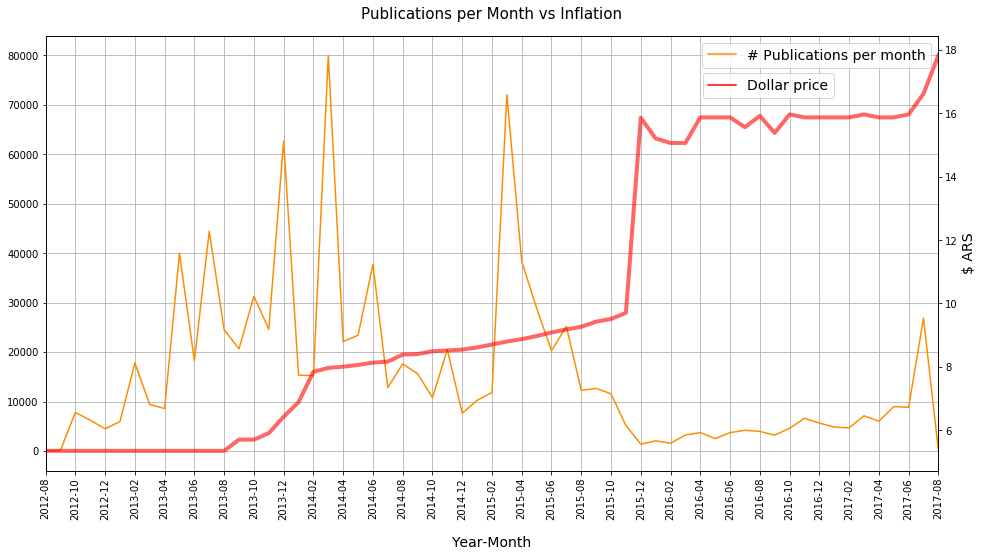

In [13]:
grouped = pd.DataFrame({'Year-Month':dfPublished.created_on.astype('str').str.slice(0, -3), 
                        'Publications':dfPublished.id})\
            .groupby(by='Year-Month')\
            .count()\
            .reset_index()

def getMonth(df, ind, col) :
    date = df.loc[ind, col]
    return str(date)[:7]

dfDollarPrice = dfPublished.loc[dfPublished.currency.str.contains('ARS', na=False) & 
                                (dfPublished.price_aprox_usd > 0)][['created_on', 'price', 'price_aprox_usd']]
dfDollarPrice = dfDollarPrice.groupby(lambda i: getMonth(dfDollarPrice, i, 'created_on'))\
                             .agg('first')    
dfDollarPrice['dollar_price'] = dfDollarPrice.apply(lambda row: row.price / row.price_aprox_usd, axis=1)
dfDollarPrice = dfDollarPrice.reset_index(drop='index')\
                             .loc[:, ('created_on', 'dollar_price')]    
dfDollarPrice.created_on = pd.Series(dfDollarPrice.created_on.astype('str').str.slice(0, -3))
dfDollarPrice.rename(columns={'created_on':'Year-Month'}, inplace=True)

grouped = grouped.merge(dfDollarPrice, how='inner', on='Year-Month')

ax = grouped.plot(x=grouped.loc[:, ('Year-Month')].astype('str'), 
                  kind='line',
                  figsize=(16, 8), 
                  xticks=range(0, len(grouped), 2), rot=90, 
                  secondary_y='dollar_price',
                  color=['DarkOrange', 'red'], 
                  title="Publications per Month vs Inflation")
ax.xaxis.label.set_size(14)
ax.xaxis.set_label_coords(0.5, -0.15)
ax.title.set_position((0.5, 1.025))
ax.title.set_size(15)
ax.grid(linestyle='solid')
ax.legend(fontsize=14).get_texts()[0].set_text("# Publications per month")
ax.right_ax.legend(fontsize=14).get_texts()[0].set_text("Dollar price")
legend = ax.right_ax.get_legend()
legend.set_bbox_to_anchor((0.891, 0.84))
ax.right_ax.get_lines()[0].set_alpha(0.6)
ax.right_ax.get_lines()[0].set_linewidth(4)
ax.right_ax.yaxis.label.set_size(14)
ax.right_ax.set_ylabel("$ ARS")
ax.set_axisbelow(True);

### Histórico de ventas vs precio del dólar:
> Podemos ver que existe una relación entre la cantidad de publicaciones de propiedades en venta que se realizan en un determinado mes con el precio del dólar.<br>El punto de inflexión más claro es a partir de **Diciembre del 2015**, donde el dólar se dispara y las publicaciones entran en un largo período de estancamiento. Ésta fecha coincide con la asunción del presidente Mauricio Macri, por lo que se puede suponer *(conociendo el contexto de la población)* que se generó una gran especulación acerca de ajustes por lo que la venta de una propiedad no sería tan viable como en el pasado.<br><br> Por otro lado no hay que dejar de notar un caso más aislado en **Febrero del 2013** donde si bien la reacción es mucho más pequeña, hay que considerar que el dólar disminuyó su precio a menos de la mitad dentro del mismo mes, dando lugar a otra posible especulación de buenas oportunidades para vender por parte de los dueños o inmobiliarias.

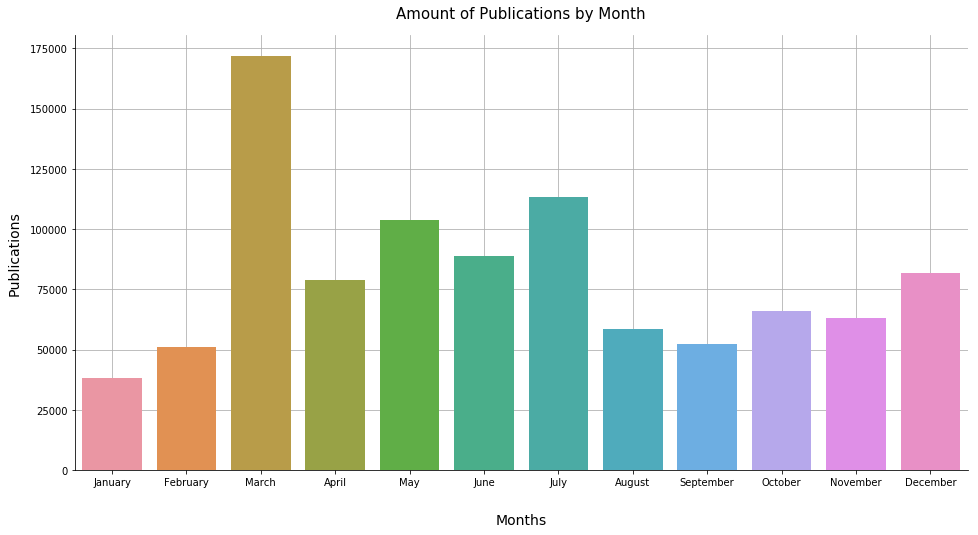

In [14]:
grouped = pd.DataFrame({'Months':pd.Series(dfPublished.created_on.dt.month), 'Publications':dfPublished.id})\
            .groupby(by='Months')\
            .count()
ax = sns.barplot(x='Months', y='Publications', data=grouped.reset_index())
ax.get_figure().set_size_inches(16,8)
ax.xaxis.set_ticklabels(calendar.month_name[1:])
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.yaxis.set_label_coords(-0.06, 0.5)
ax.xaxis.set_label_coords(0.5, -0.10)
ax.title.set_text('Amount of Publications by Month')
ax.title.set_position((0.5, 1.025))
ax.title.set_size(15)
ax.grid(linestyle='solid')
ax.set_axisbelow(True)
sns.despine();

### Histórico de publicaciones en buckets según mes
>Observamos que los meses con mayores ventas historicamente son **Marzo**, **Julio** y **Mayo**, mientras que desde Agosto hasta fin de las vacaciones de verano, la cantidad de publicaciones nuevas es mucho menor.

___
# Variables VS Precio
___

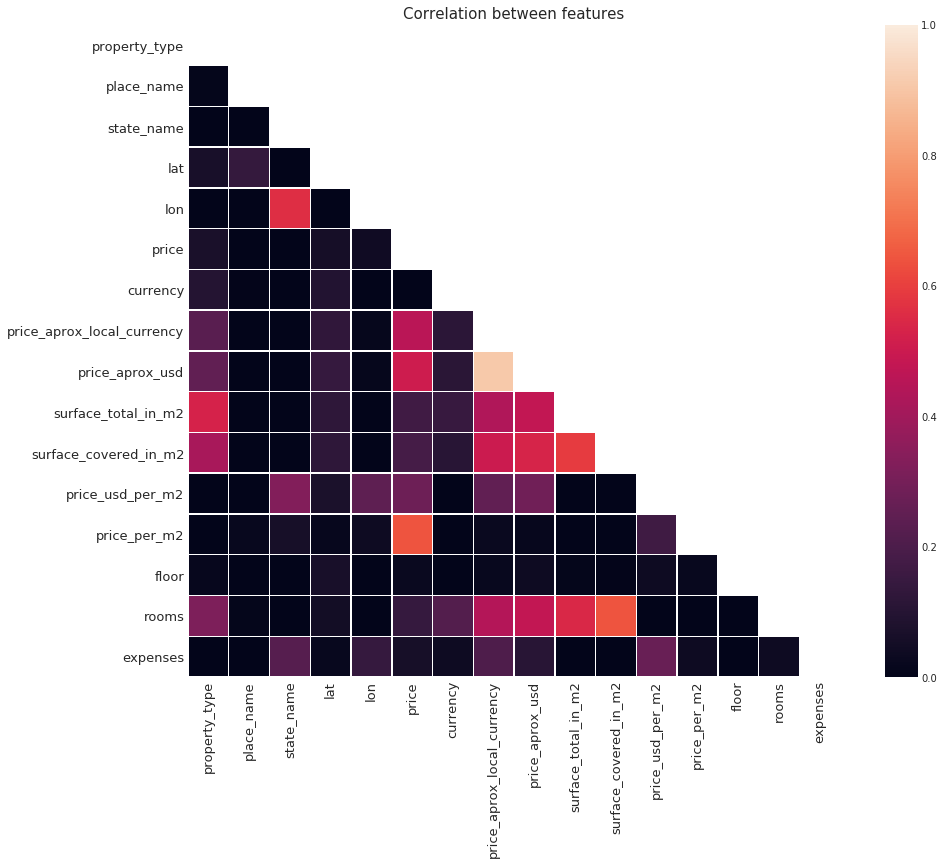

In [15]:
dfCorr = dfReset[:]

dfCorr.currency = dfCorr.currency.cat.codes
dfCorr.state_name = dfCorr.state_name.cat.codes
dfCorr.place_name = dfCorr.place_name.cat.codes
dfCorr.property_type = dfCorr.property_type.cat.codes
dfCorr = dfCorr.corr()

mask = np.zeros_like(dfCorr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(dfCorr, mask=mask, vmin=0.0, vmax=1.0, linewidths=.5, square=True)

ax.get_figure().set_size_inches(16,12)
ax.tick_params(labelsize=13)
ax.set_title("Correlation between features", fontdict={'size':15});

### Features con relaciones entre ellas
>Luego de tratar las columnas categóricas *(convertirlas a valores númericos)* para poder evaluar correlación entre ellas, se realiza un HeatMap que nos otorga un poco de información acerca de la naturaleza del set de datos.
Muchas columnas tienen relaciones obvias como la columna de precio en dólares y en pesos, por lo que vamos a quedarnos con un subset de este plot para una lectura más clara.

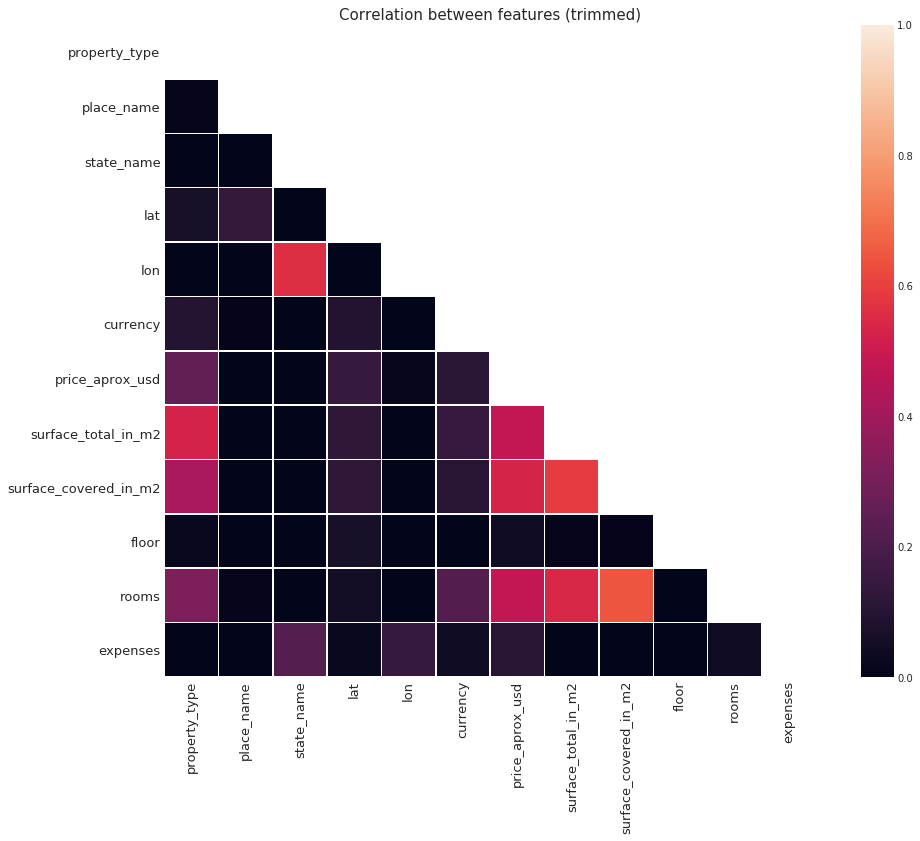

In [16]:
dfCorr = dfReset[:]
dfCorr = dfCorr.drop(['id', 'price', 'price_aprox_local_currency', 'price_per_m2', 'price_usd_per_m2', 'created_on'], axis=1)
dfCorr.currency = dfCorr.currency.cat.codes
dfCorr.state_name = dfCorr.state_name.cat.codes
dfCorr.place_name = dfCorr.place_name.cat.codes
dfCorr.property_type = dfCorr.property_type.cat.codes
dfCorr = dfCorr.corr()

mask = np.zeros_like(dfCorr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(dfCorr, mask=mask, vmin=0.0, vmax=1.0, linewidths=0.5, square=True)

ax.get_figure().set_size_inches(16,12)
ax.tick_params(labelsize=13)
ax.set_title("Correlation between features (trimmed)", fontdict={'size':15});


### Analizando el recorte
>La mayoría de las relaciones que se observan son bastante intuitivas. Otras que de antemano se pensó que seguro aparecian, no se hicieron presentes; como por ejemplo, la localidad con el precio de la propiedad.

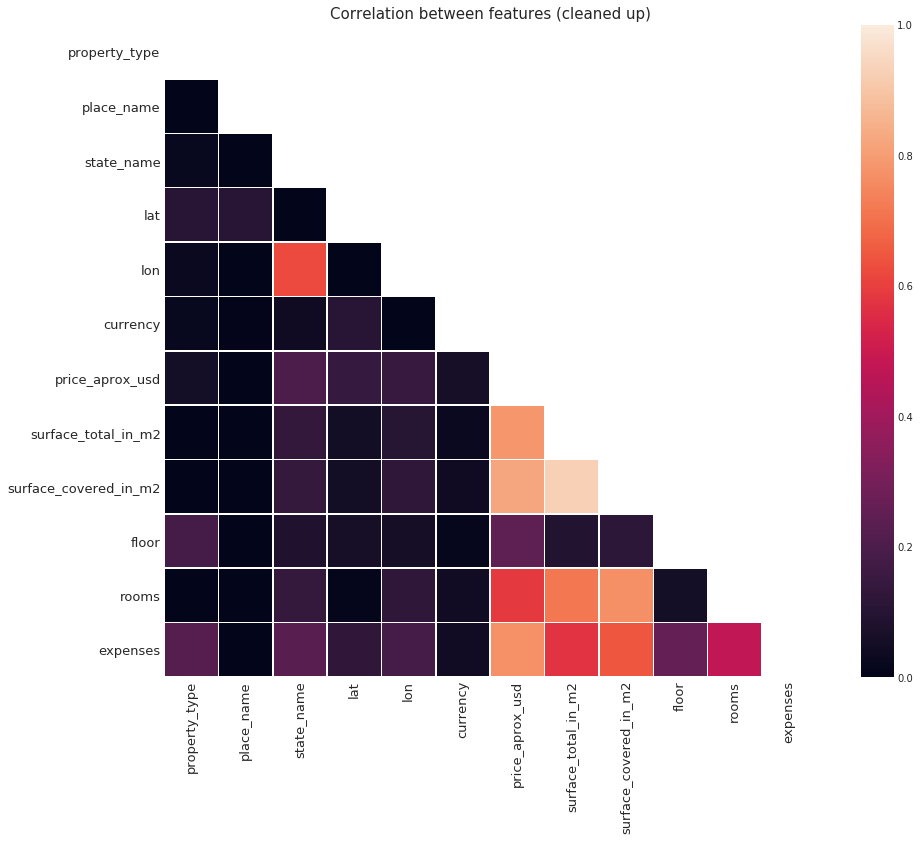

In [17]:
dfCorr = dfPublished.drop(['id', 'price', 'price_aprox_local_currency', 'price_per_m2', 'price_usd_per_m2', 'created_on'], axis=1)
dfCorr = dfCorr.dropna()

dfCorr.currency = dfCorr.currency.cat.codes
dfCorr.state_name = dfCorr.state_name.cat.codes
dfCorr.place_name = dfCorr.place_name.cat.codes
dfCorr.property_type = dfCorr.property_type.cat.codes
corr = dfCorr.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmin=0.0, vmax=1.0, linewidths=.5, square=True)

ax.get_figure().set_size_inches(16,12)
ax.tick_params(labelsize=13)
ax.set_title("Correlation between features (cleaned up)", fontdict={'size':15});

### Buscando relaciones más fuertes

>El objetivo del plot de arriba es mostrar la correlación entre los features luego de limpiar de registros NaN al DataFrame. Por más que se pierden muchos registros, tenemos un gráfico que muestra mayor cantidad de relaciones que el anterior.<br>
Entre ellas, podemos ver que el precio en dólares mantiene una relación con las expensas, la cantidad de habitaciones y la superficie total.

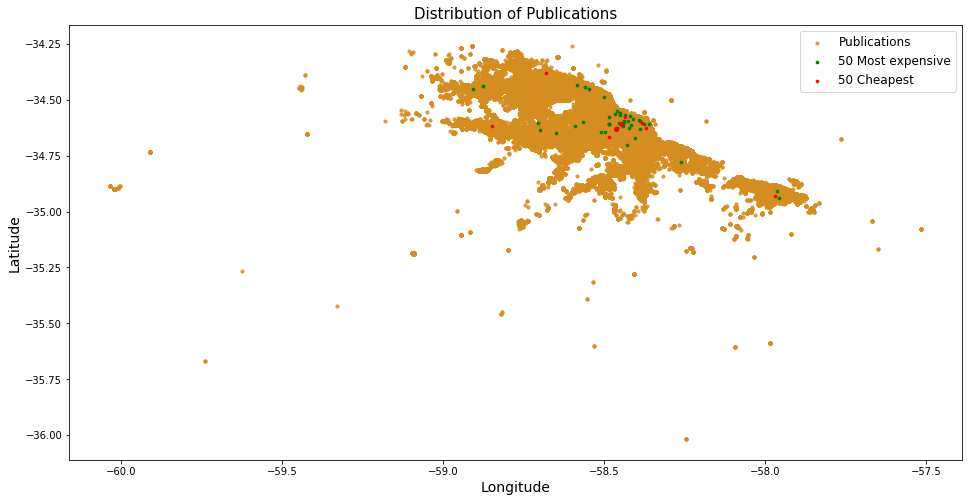

In [18]:
dfScatter = dfPublished.dropna(subset=['lat', 'lon'])

ax = dfScatter.plot(kind='scatter', 
                    figsize=(16, 8), 
                    x='lon', y='lat', 
                    c='#d68d20', s=10, alpha=0.8, label='Publications')

ax = dfScatter.head(50).plot(kind='scatter', ax=ax, x='lon', y='lat', c='green', s=7, label='50 Most expensive')
ax = dfScatter.tail(50).plot(kind='scatter', ax=ax, x='lon', y='lat', c='red', s=7, label = '50 Cheapest')
ax.yaxis.set_label_text('Latitude')
ax.xaxis.set_label_text('Longitude')
ax.set_title("Distribution of Publications", fontdict={'size':15})
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.legend(fontsize=12);

### Distribución de las publicaciones
>En el plot se observan geográficamente las publicaciones distribuidas como puntos. El gran cluster que se ve es Capital Federal y el Conurbano. Se agregaron las posiciones de las 50 publicaciones más caras y las 50 más baratas.

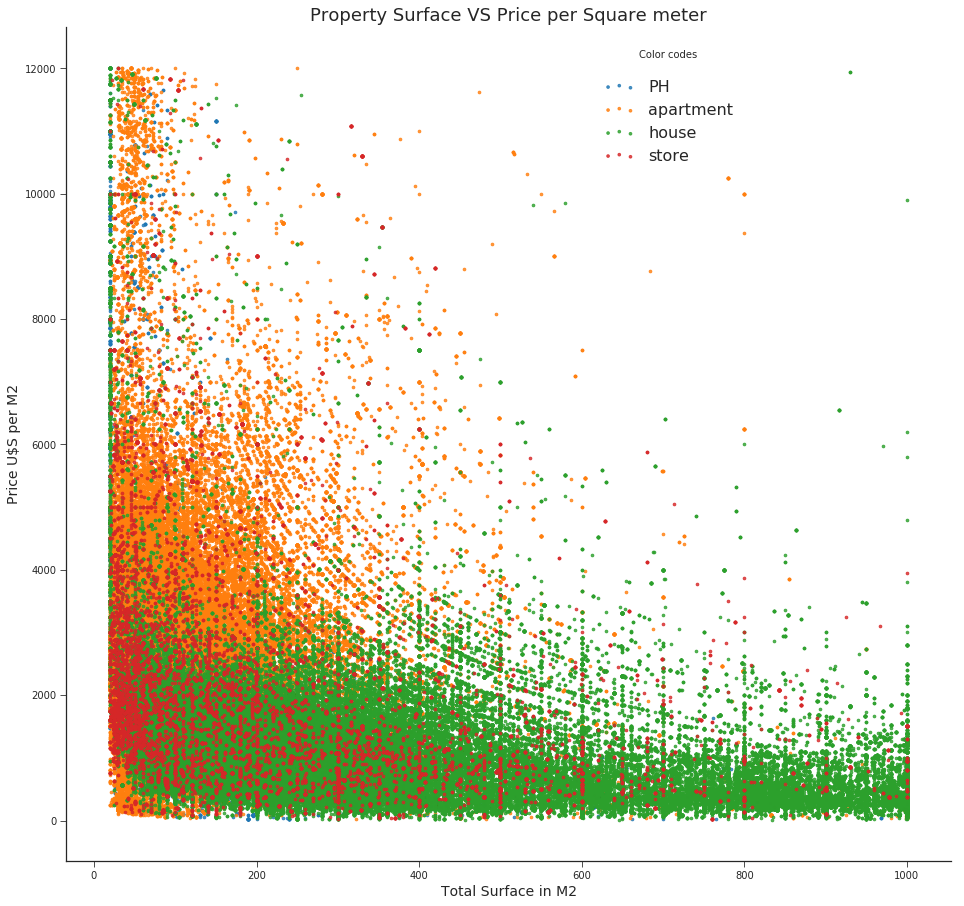

In [36]:
dfScatter = dfPublished.dropna(subset=['price_usd_per_m2'])\
                       .loc[:, ('property_type', 'surface_total_in_m2', 'price_usd_per_m2')]

sns.set_style("ticks", rc={'legend.scatterpoints': 3})
            
ax = sns.lmplot(x='surface_total_in_m2', 
                y='price_usd_per_m2', 
                hue='property_type', 
                data=dfScatter, 
                fit_reg=False, 
                scatter_kws={"s":7}, legend_out=False)

ax.fig.set_size_inches(16,14)
plt.legend(loc='upper right', fontsize=16, title='Color codes\n', bbox_to_anchor=(0.77, 0.99))
ax.set_ylabels(label="Price U$S per m2", fontsize=14)
ax.set_xlabels(label="Total Surface in m2", fontsize=14)
ax.fig.axes[0].set_title("Property Surface VS Price per Square meter", fontsize=18);

### Superficie m² VS Precio por m²
>En éste gráfico vemos en conjunto a los 4 tipos de propiedades y su distribución según su precio y tamaño. En general se nota un patrón de que a mayor cantidad de superficie, menor el precio de cada m² en ella.<br>
También se puede notar junto a todo lo que se estuvo analizando en plots previos, que este set de datos contiene una gran cantidad de outliers o al menos casos raros como por ejemplo: *muchas propiedades con la misma exacta cantidad de m².*

In [37]:
dfApartments = dfScatter.loc[dfScatter.property_type.str.contains('apartment'), ('surface_total_in_m2', 'price_usd_per_m2')]
dfHouses = dfScatter.loc[dfScatter.property_type.str.contains('house'), ('surface_total_in_m2', 'price_usd_per_m2')]
dfPH = dfScatter.loc[dfScatter.property_type.str.contains('PH'), ('surface_total_in_m2', 'price_usd_per_m2')]
dfStores = dfScatter.loc[dfScatter.property_type.str.contains('store'), ('surface_total_in_m2', 'price_usd_per_m2')]

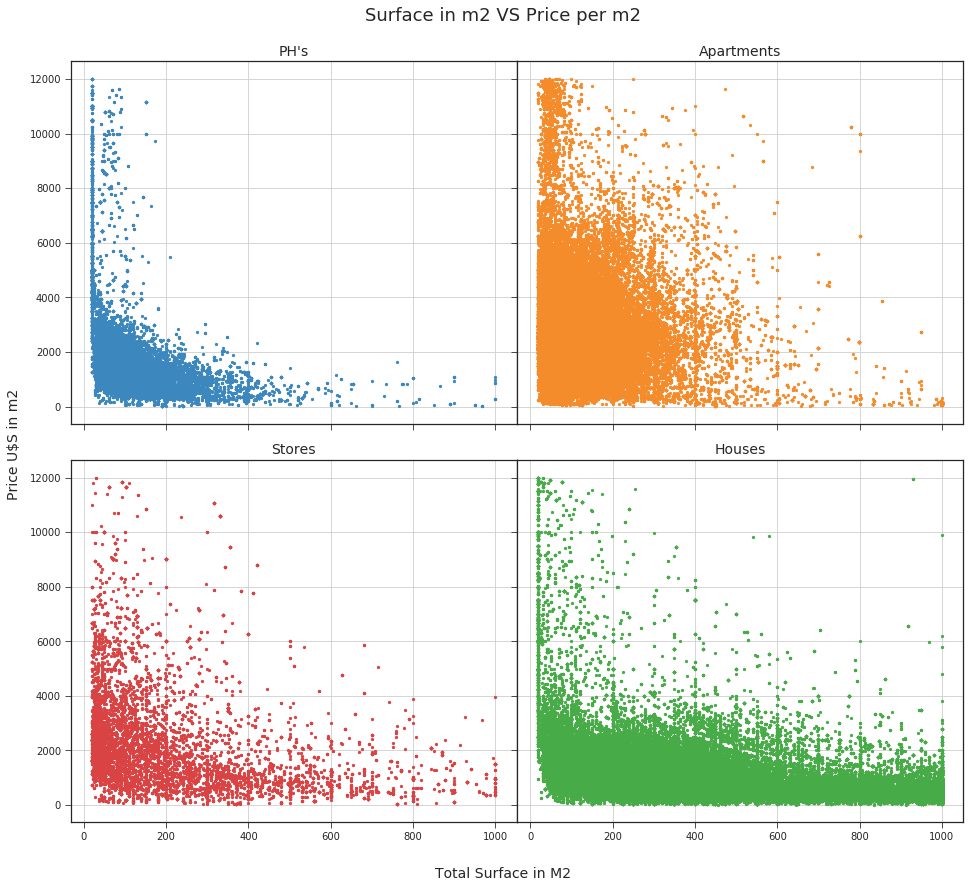

In [88]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(16,14))

ax1.set_title('PH\'s', fontsize=14)
ax1.scatter(x=dfPH.surface_total_in_m2, y=dfPH.price_usd_per_m2, 
            color='#3c87bd', s=5)

ax2.set_title('Apartments', fontsize=14)
ax2.scatter(x=dfApartments.surface_total_in_m2, y=dfApartments.price_usd_per_m2, 
            color='#f48c2b', s=5)

ax3.set_title('Stores', fontsize=14)
ax3.scatter(x=dfStores.surface_total_in_m2, y=dfStores.price_usd_per_m2, 
            color='#da4344', s=5)

ax4.set_title('Houses', fontsize=14)
ax4.scatter(x=dfHouses.surface_total_in_m2, y=dfHouses.price_usd_per_m2, 
            color='#47ab47', s=5)

f.subplots_adjust(hspace=0.1, wspace=0)
f.text(0.5, 0.92, 'Surface in m2 VS Price per m2', ha='center', fontsize=18)
f.text(0.5, 0.070, 'Total Surface in M2', ha='center', fontsize=14)
f.text(0.070, 0.5, 'Price U$S in m2', va='center', rotation='vertical', fontsize=14)

ax1.grid('on')
ax2.grid('on')
ax3.grid('on')
ax4.grid('on');

### Detalle de distribución entre tipos de propiedades según superficie y precio
>Este gráfico brinda mucha información que permite contrastar los tipos de propiedades y algunas particularidades entre ellos:
+ En general el precio del m² en las casas es menor que en los departamentos.
+ Los PH, en general, tienen una buena relación superficie-precio.
+ Los departamentos tienen un precio alto por m².